In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

This data is downloaded from https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

I have already modified data and saved it in car_data1.xlsx file, so that it can be read as excel.

In [2]:
data=pd.read_excel('car_data1.xlsx')

## EDA

In [3]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Get info of dataset and check for null values if any

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying      1728 non-null object
maint       1728 non-null object
doors       1728 non-null object
persons     1728 non-null object
lug_boot    1728 non-null object
safety      1728 non-null object
class       1728 non-null object
dtypes: object(7)
memory usage: 108.0+ KB


As all the columns are categorical, check for unique values of each column

In [5]:
for i in data.columns:
    print(data[i].unique(),"\t",data[i].nunique())
    

['vhigh' 'high' 'med' 'low'] 	 4
['vhigh' 'high' 'med' 'low'] 	 4
['2' '3' '4' '5more'] 	 4
['2' '4' 'more'] 	 3
['small' 'med' 'big'] 	 3
['low' 'med' 'high'] 	 3
['unacc' 'acc' 'vgood' 'good'] 	 4


Check how these unique categories are distributed among the columns

In [6]:
for i in data.columns:
    print(data[i].value_counts())
    print()

vhigh    432
low      432
high     432
med      432
Name: buying, dtype: int64

vhigh    432
low      432
high     432
med      432
Name: maint, dtype: int64

2        432
3        432
4        432
5more    432
Name: doors, dtype: int64

more    576
2       576
4       576
Name: persons, dtype: int64

big      576
small    576
med      576
Name: lug_boot, dtype: int64

low     576
high    576
med     576
Name: safety, dtype: int64

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64



From above output, it is clear that all the columns except 'class' are distributed equally among data.

Below is the graph which gives the count of unique values in column.

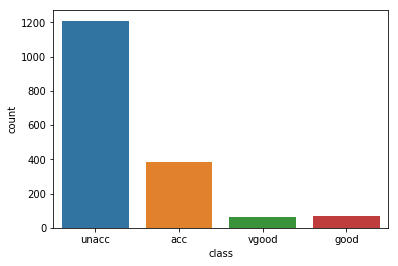

In [7]:
sns.countplot(data['class'])

It can be seen from the graph that the result 'class' is unbalanced with larger values of 'unacc'.
So, this is an unbalanced multiclass classification problem.

I've checked how the 'class' is distributed for each of the feature in our data.

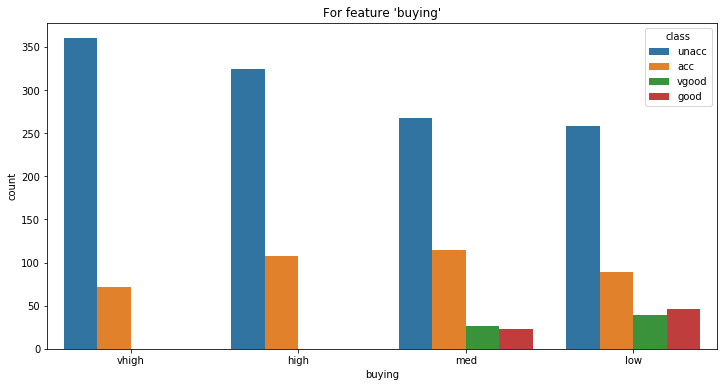

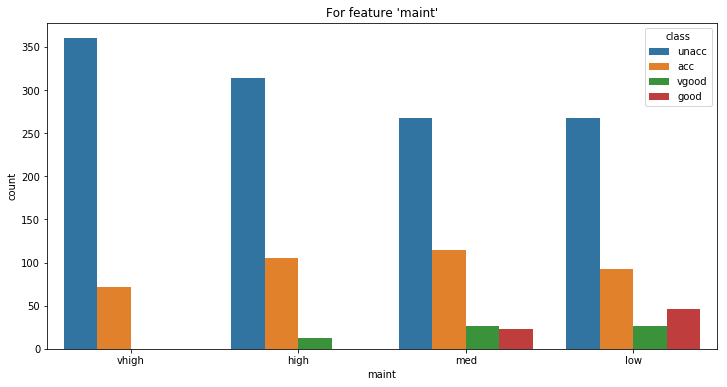

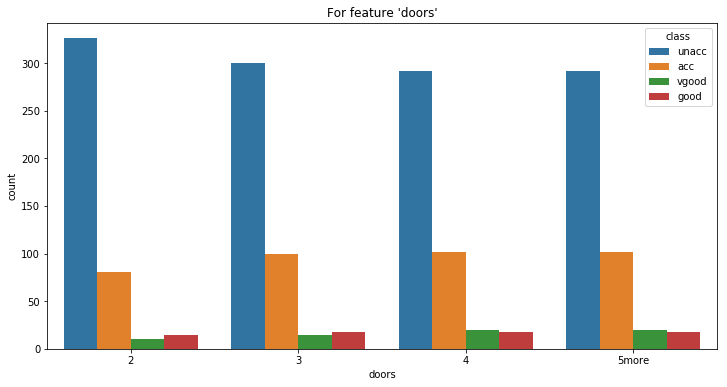

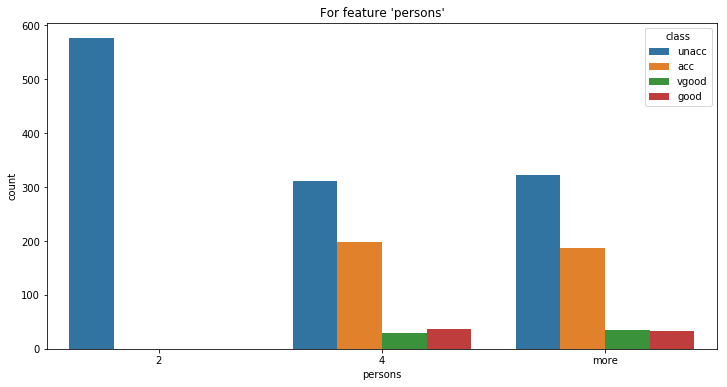

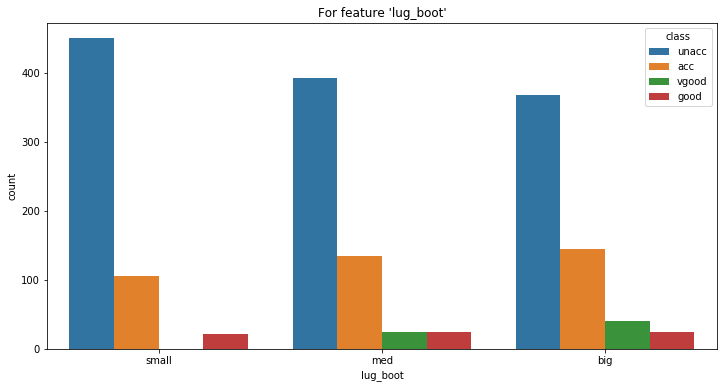

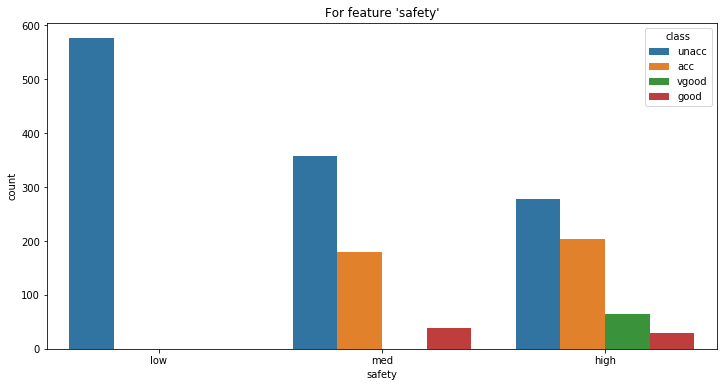

In [8]:
for i in data.columns[:-1]:
    plt.figure(figsize=(12,6))
    plt.title("For feature '%s'"%i)
    sns.countplot(data[i],hue=data['class'])

As scikit-learn algorithms do not generally work with string values, I've converted string categories to integers.

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le=LabelEncoder()

In [11]:
for i in data.columns:
    data[i]=le.fit_transform(data[i])

In [12]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


Heatmap of the columns on dataset with each other. It shows Pearson's correlation coefficient of column w.r.t other columns.

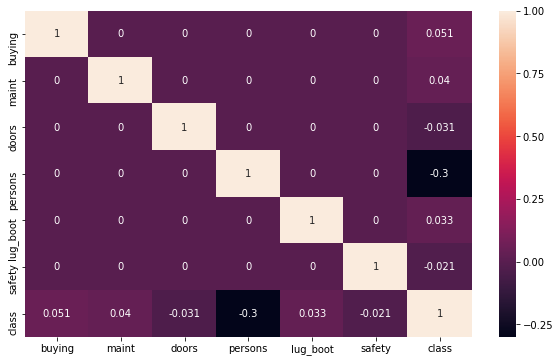

In [13]:
fig=plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),annot=True)

Ignoring the diagonal values, it can be seen that most of the columns shows very weak correlation with 'class'.
'persons' column is showning a weak relation with 'class'.
Other columns except 'class' shows no correlation with each other.

So, plotting these columns with each other or doing any analysis on them may not give any productive output.

X is the dataframe containing input data / features

y is the series which has results which are to be predicted.

In [14]:
X=data[data.columns[:-1]]
y=data['class']

In [15]:
X.head(2)

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2


Divide data in train and test sets

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Selection

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [19]:
logreg=LogisticRegression(solver='newton-cg',multi_class='multinomial')

In [20]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
pred=logreg.predict(X_test)

In [22]:
logreg.score(X_test,y_test)

0.6647398843930635

So, basic logistic regression model is giving very less accuracy. Let's check the learning curves

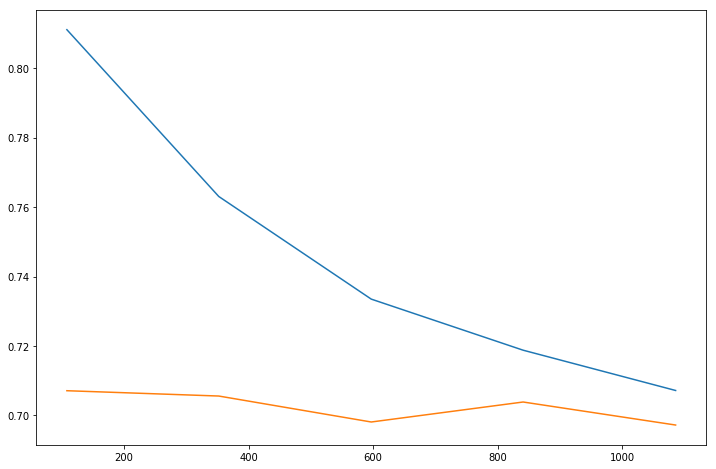

In [23]:
from sklearn.model_selection import learning_curve
lc=learning_curve(logreg,X_train,y_train,cv=10,n_jobs=-1)
size=lc[0]
train_score=[lc[1][i].mean() for i in range (0,5)]
test_score=[lc[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(12,8))
plt.plot(size,train_score)
plt.plot(size,test_score)

From above graph, with the increasing number of samples, train accuracy is decreasing.

I tried modifying regularization parameter

In [24]:
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve
param_range=[0.0001,0.001,0.1,1]
curve=validation_curve(logreg,X_train,y_train,cv=5,param_name='C',
    param_range=param_range,n_jobs=-1,)

In [25]:
curve

(array([[0.70569948, 0.70423992, 0.70454545, 0.70454545, 0.70454545],
        [0.70569948, 0.70423992, 0.70454545, 0.70454545, 0.70454545],
        [0.70777202, 0.71768356, 0.70661157, 0.71384298, 0.7107438 ],
        [0.70466321, 0.71044467, 0.7035124 , 0.70454545, 0.70764463]]),
 array([[0.70081967, 0.70661157, 0.70539419, 0.70539419, 0.70539419],
        [0.70081967, 0.70661157, 0.70539419, 0.70539419, 0.70539419],
        [0.73770492, 0.66942149, 0.71369295, 0.70954357, 0.70124481],
        [0.70491803, 0.67355372, 0.70124481, 0.70954357, 0.70539419]]))

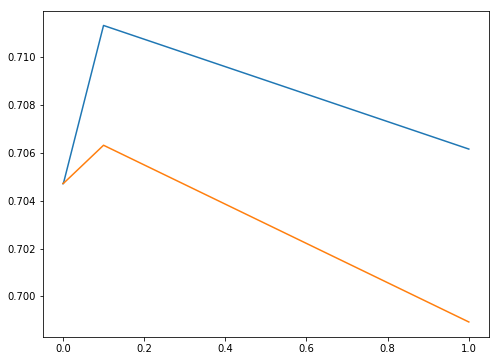

In [26]:
n=len(param_range)
train_score=[curve[0][i].mean() for i in range (0,n)]
test_score=[curve[1][i].mean() for i in range (0,n)]
fig=plt.figure(figsize=(8,6))
plt.plot(param_range,train_score)
plt.plot(param_range,test_score)
plt.xticks=param_range

It clear that C=0.1 is giving a good result.

Now, as it is a multiclass classification, I tired using 'newton-cg','sag','lgfbs' solvers.

As this dataset is smaller, we can use GridSearch to get best possible parameters

In [27]:
param_grid={'C':[0.01,0.1,1,10],
           'solver':['newton-cg', 'lbfgs', 'sag'],
           'multi_class':['multinomial']}
grid=GridSearchCV(estimator=LogisticRegression(n_jobs=-1),param_grid=param_grid,cv=5,n_jobs=-1)

In [28]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'multi_class': ['multinomial']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 0.01, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.7096774193548387


So, with the above parameters, we can get at accuary of 71%.

As it is an unbalanced classification problem, accuracy can't be a good criterion for evaluation. But accuary itself is very low, so, I didn't check for other criteria.

### KNN Classifier
As logistic regression didn't give accuracy, I tried KNN classification

In [30]:
knn=KNeighborsClassifier(n_jobs=-1)

In [31]:
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
knn.score(X_test,y_test)


0.9017341040462428

So, the default KNN classificaton model is giving an accuracy of 90%

In [32]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       118
           1       0.77      0.53      0.62        19
           2       0.93      0.99      0.96       358
           3       1.00      0.50      0.67        24

   micro avg       0.90      0.90      0.90       519
   macro avg       0.88      0.70      0.76       519
weighted avg       0.90      0.90      0.90       519



As I said earlier accuracy can't be a fair criterion to evaluate unbalanced classification, so I checked for 'f1-score'

f1-score is 0.9 which is better than previous model

Now I checked for various parameters for 'n_neighbours'. You can do it by grid_Search directly, but I did it using the code given below so that I can visualize the effect of n_neighbours.

In [33]:
avg_score=[]
for k in range(2,30):
    knn=KNeighborsClassifier(n_jobs=-1,n_neighbors=k)
    score=cross_val_score(knn,X_train,y_train,cv=5,n_jobs=-1,scoring='accuracy')
    avg_score.append(score.mean())

Text(0, 0.5, 'accuracy')

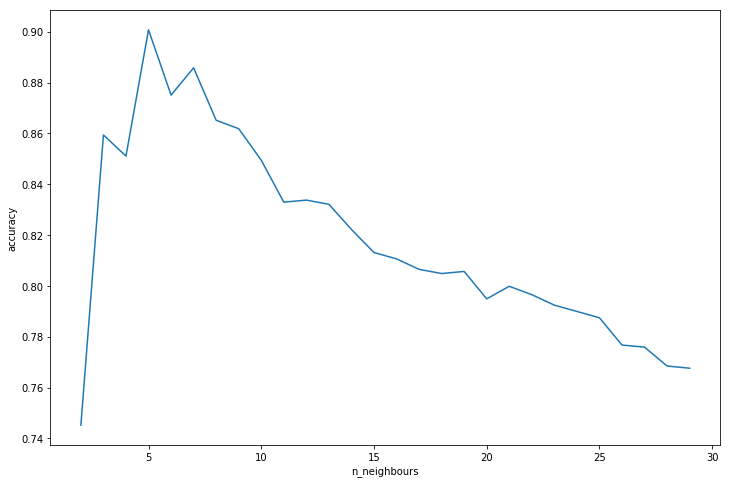

In [34]:
plt.figure(figsize=(12,8))
plt.plot(range(2,30),avg_score)
plt.xlabel("n_neighbours")
plt.ylabel("accuracy")
#plt.xticks(range(2,30,2))

So, n_neighbours=5 is giving better accuracy as well as f1-score for our data.

So, with KNN Classification algorithm, we are able to achieve accuracy around 90%

### Random Forests Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rfc=RandomForestClassifier(n_jobs=-1,random_state=51)

In [37]:
from sklearn.metrics import f1_score
rfc.fit(X_train,y_train)
print(rfc.score(X_test,y_test))
print(f1_score(y_test,rfc.predict(X_test),average='macro'))

E:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9499036608863198
0.8843956728712123


So, the basic model of RFC is giving 95% accuracy.

Now, check the effect of n_estimators on the model

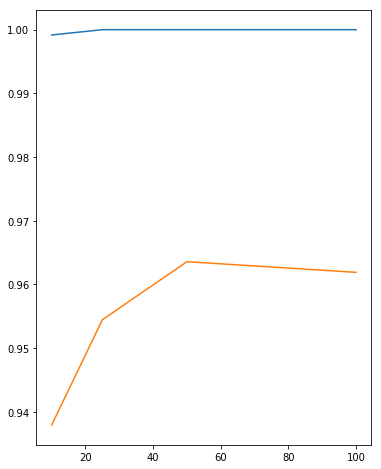

In [38]:
param_range=[10,25,50,100]
curve=validation_curve(rfc,X_train,y_train,cv=5,param_name='n_estimators',
    param_range=param_range,n_jobs=-1)

train_score=[curve[0][i].mean() for i in range (0,len(param_range))]
test_score=[curve[1][i].mean() for i in range (0,len(param_range))]
fig=plt.figure(figsize=(6,8))
plt.plot(param_range,train_score)
plt.plot(param_range,test_score)
plt.xticks=param_range

So, with the increasing n_estimators, test accuracy is increasing. Model is evaluating best at n_estimators=50. After n_estimators=50,model starts overfitting.
Now, we've reached approx. 96.3% accuracy.

Now, check how the model fits for various values of 'max_features'

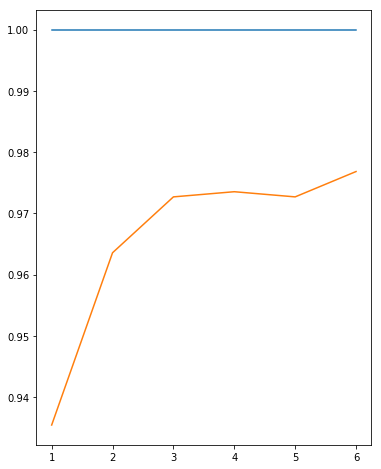

In [39]:
param_range=range(1,len(X.columns)+1)
curve=validation_curve(RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=51),X_train,y_train,cv=5,
    param_name='max_features',param_range=param_range,n_jobs=-1)

train_score=[curve[0][i].mean() for i in range (0,len(param_range))]
test_score=[curve[1][i].mean() for i in range (0,len(param_range))]
fig=plt.figure(figsize=(6,8))
plt.plot(param_range,train_score)
plt.plot(param_range,test_score)
plt.xticks=param_range

From above graph, it is clear that model is giving best resut for max_features=6. Still the model is overfitting.

Now we've reached 97.7% accuracy approx.

We can also check of other parameters like 'max_depth','criterion',etc using above code.

Another simple way is to use GridSearch to get combination of best parameters. As this dataset is small, GridSearch will take less time to complete.


In [40]:
param_grid={'criterion':['gini','entropy'],
           'max_depth':[2,5,10,20],
           'max_features':[2,4,6,'auto'],
           'max_leaf_nodes':[2,3,None],}

In [41]:
grid=GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=51),
                  param_grid=param_grid,cv=10,n_jobs=-1)

In [42]:
grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=51, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 10, 20], 'max_features': [2, 4, 6, 'auto'], 'max_leaf_nodes': [2, 3, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 6, 'max_leaf_nodes': None}
0.9842845326716294


So, with above parameters for RFC, we've reached 98.42% accuracy.

#### Learning Curve

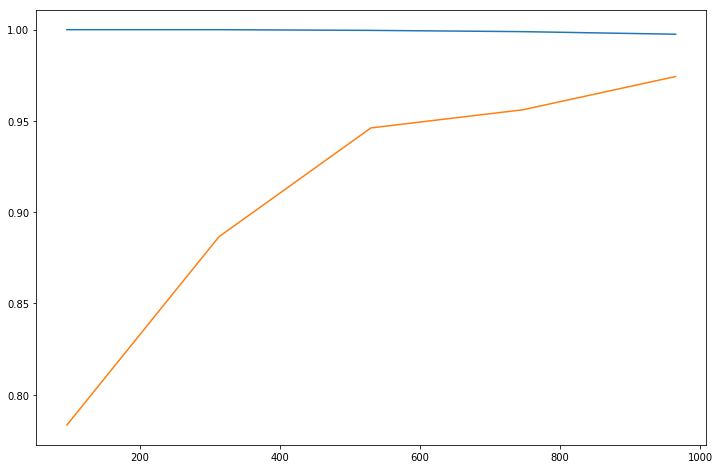

In [44]:
lc=learning_curve(RandomForestClassifier(n_estimators=50,criterion='entropy',max_features=6,max_depth=10,random_state=51,
                                             max_leaf_nodes=None,n_jobs=-1,),X_train,y_train,cv=5,n_jobs=-1)
size=lc[0]
train_score=[lc[1][i].mean() for i in range (0,5)]
test_score=[lc[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(12,8))
plt.plot(size,train_score)
plt.plot(size,test_score)

##### Model is overfitting as train accuracy is 1 ,but test accuracy is much less.
I've already tried changing RFC parameters to tackle overfitting. But, still it is not reduced.
To reduce variance, we can
1. Increase number of samples. (It is clear from above graph that incresing number of samples will improve model)
2. Reduce number of features



In [45]:
print(X.columns)
print(rfc.feature_importances_)

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object')
[0.19994491 0.16920712 0.06810586 0.23825178 0.08452991 0.23996042]


From feature importances, it is clear that 'doors' feature is least important.
So, train our model excluding that feature.

In [46]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X[['buying', 'maint', 'persons', 'lug_boot', 'safety']],
    y, test_size=0.3, random_state=42)

In [47]:
rfc1=RandomForestClassifier(n_estimators=50,criterion='entropy',max_features=5,max_depth=10,random_state=51,
    max_leaf_nodes=None,n_jobs=-1)
rfc1.fit(X_train1,y_train1)
rfc1.score(X_test1,y_test1)


0.9364161849710982

Our data already has less features and even if we drop the least important feature, then also the accuracy is reducing to 93.64%

So, dropping a feature is not an option to reduce variance in our model.

The only option we are left with is to get more data.

## Conclusion
Random Forest Classifier is the best suitable model for this data with following parameters:
n_estimators: 50
criterion: entropy
max_depth: 10
max_features: 6
max_leaf_nodes: None

We are able to achieve 98.43% accuracy with this model